# Self-Oranganizing Map

Ce notebook a comme but de voir ce qu'un SOM peut faire avec nos données.

## Tests avec notre dataset

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely import wkt
from sklearn.preprocessing import StandardScaler
from sklearn_som.som import SOM

In [2]:
csv_path = '../../data/processed/processed_enhanced_swiss_data.csv'

# Lecture du GeoDataFrame à partir du CSV
gdf = pd.read_csv(csv_path)

gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.set_crs(epsg=2056, inplace=True)
gdf.set_index("idx", inplace=True)

gdf.head()

,geometry,Altitude,NaturalHabitat,SoilType,WaterRetention,NutrientContent,WaterPermeability,Temperature
idx,,,,,,,,
35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2
36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2
261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3
262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3
263,"POLYGON ((2486071.58 1111261.72, 2487071.58 11...",352.9472,82.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.3


In [3]:
gdf['x'] = None
gdf['y'] = None

for idx, row in gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    gdf.at[idx, 'x'] = x[0]
    gdf.at[idx, 'y'] = y[0]


In [4]:
# Affecte les bons type aux colonnes
gdf['Altitude'] = gdf['Altitude'].astype(float)
gdf['NaturalHabitat'] = gdf['NaturalHabitat'].astype(float)
gdf['WaterRetention'] = gdf['WaterRetention'].astype(float)
gdf['NutrientContent'] = gdf['NutrientContent'].astype(float)
gdf['WaterPermeability'] = gdf['WaterPermeability'].astype(float)
gdf['Temperature'] = gdf['Temperature'].astype(float)

# Drop the geometry column
gdf = gdf.drop(columns=['geometry'])

In [5]:
# Étape 1 : Fractionner les chaînes de caractères en listes
gdf['SoilType_split'] = gdf['SoilType'].str.split('; ')

# Étape 2 : Identifier tous les mots uniques
all_labels = set(label.strip() for sublist in gdf['SoilType_split'] for label in sublist)

# Étape 3 : Créer des colonnes dummies
for label in all_labels:
    gdf["SoilType_"+label] = gdf['SoilType_split'].apply(lambda x: label in x)

# Supprimer la colonne temporaire si nécessaire
gdf = gdf.drop(columns=['SoilType_split'])
gdf = gdf.drop(columns=['SoilType'])

In [6]:
# Dummies NaturalHabitat, WaterRetention, NutrientContent et WaterPermeability
gdf = pd.get_dummies(gdf, columns=['NaturalHabitat', 'WaterRetention', 'NutrientContent', 'WaterPermeability'])

In [7]:
# Normalisation des données numériques

scaler = StandardScaler()

gdf[['Altitude', 'x', 'y', 'Temperature']] = scaler.fit_transform(gdf[['Altitude', 'x', 'y', 'Temperature']])

In [8]:
#Remove x and y columns
gdfWithoutCoordinate = gdf.drop(columns=['x', 'y'])

In [9]:
gdf.shape

(42417, 92)

In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(gdfWithoutCoordinate)

In [11]:
som = SOM(m=25, n=25, dim=data_scaled.shape[1], lr=0.6, max_iter=2000, random_state=420)
som.fit(data_scaled) 

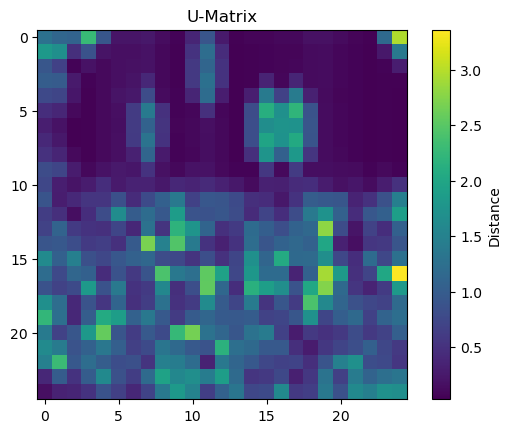

In [12]:
def plot_u_matrix(som):
    umatrix = np.zeros((som.m, som.n))
    for i in range(som.m):
        for j in range(som.n):
            # Calculate distances to neighbors
            neighbors = []
            if i > 0: neighbors.append(som.weights[i-1, j])
            if i < som.m-1: neighbors.append(som.weights[i+1, j])
            if j > 0: neighbors.append(som.weights[i, j-1])
            if j < som.n-1: neighbors.append(som.weights[i, j+1])
            # Average distance to neighbors
            umatrix[i, j] = np.mean([np.linalg.norm(som.weights[i, j] - n) for n in neighbors])

    # Plot as heatmap
    plt.imshow(umatrix, cmap='viridis')
    plt.colorbar(label='Distance')
    plt.title('U-Matrix')
    plt.show()

# Call the function
plot_u_matrix(som)

In [13]:
som.weights.shape

(625, 90)

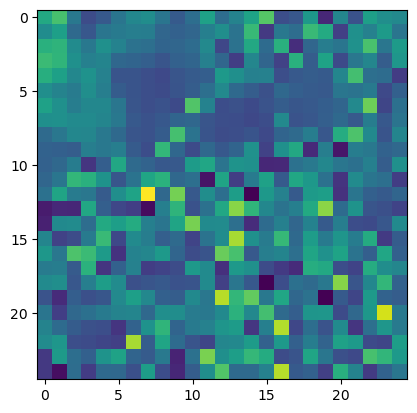

In [14]:
plt.imshow(np.reshape(som.weights[:,0], (25, 25)))

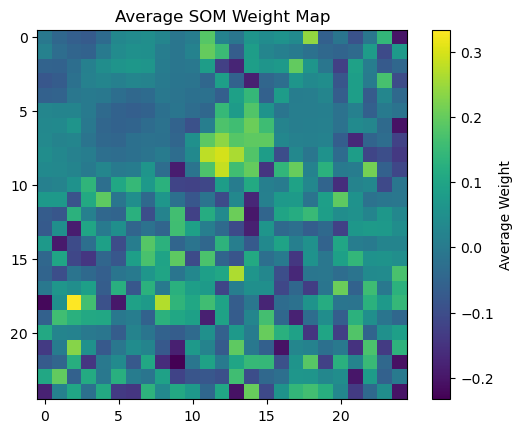

In [15]:
# Compute the average weights across all features
average_weights = np.mean(som.weights, axis=1)

# Reshape the average weights to the SOM grid shape
average_weights_reshaped = np.reshape(average_weights, (25, 25))

# Plot the average map
plt.imshow(average_weights_reshaped, cmap='viridis')
plt.colorbar(label='Average Weight')
plt.title('Average SOM Weight Map')
plt.show()

La carte auto-organisatrice n'arrive pas à séparer nos données correctement